
# Regularized Linear Models
- data
    - House Prices: Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting
    - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
    
- https://www.kaggle.com/apapiu/regularized-linear-models


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("data/train/train.csv")
test = pd.read_csv("data/test/test.csv")
print("train shape: ", train.shape)

train shape:  (1460, 81)


In [3]:
train

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e4b6a0668>,
      dtype=object)

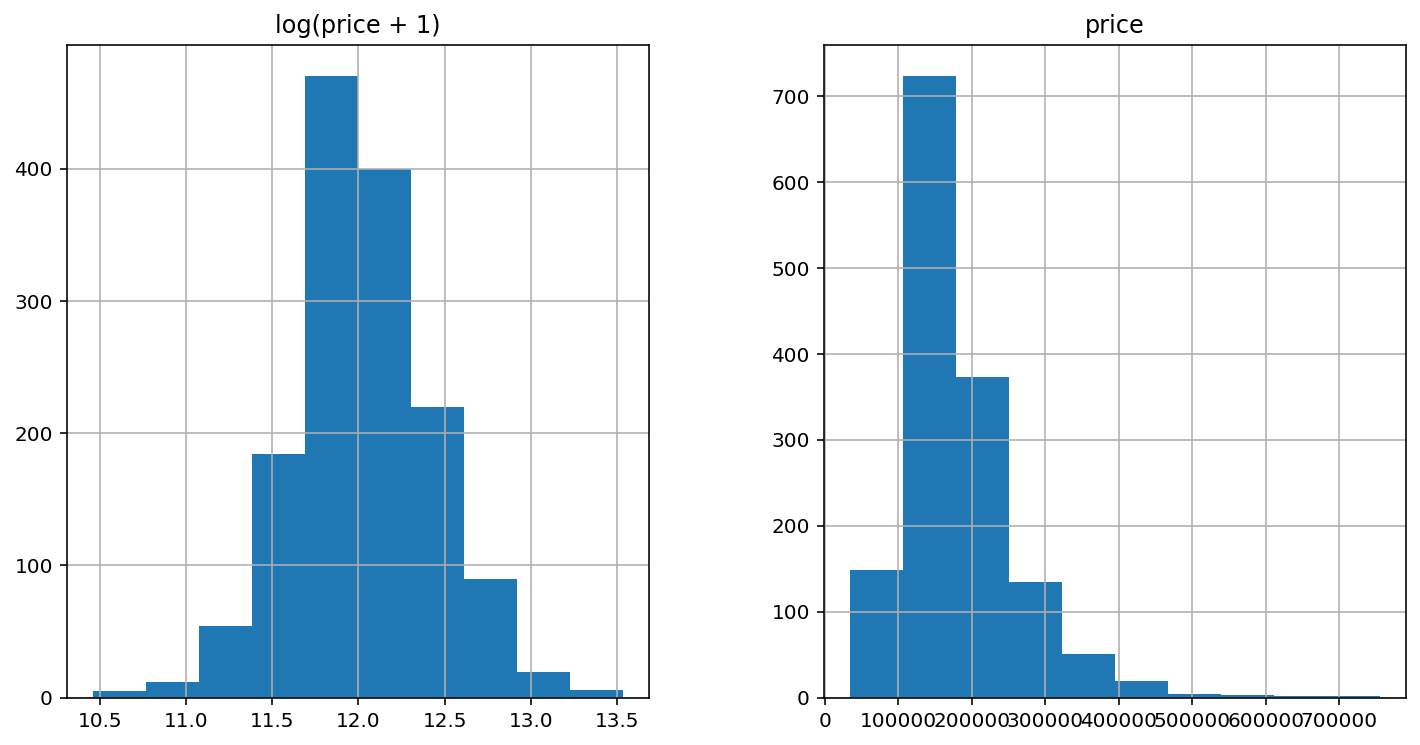

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data)
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [8]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [9]:
X_train.shape
X_train.isnull().sum().sum()

0

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [11]:
model_ridge = Ridge()

In [12]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [0.05]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

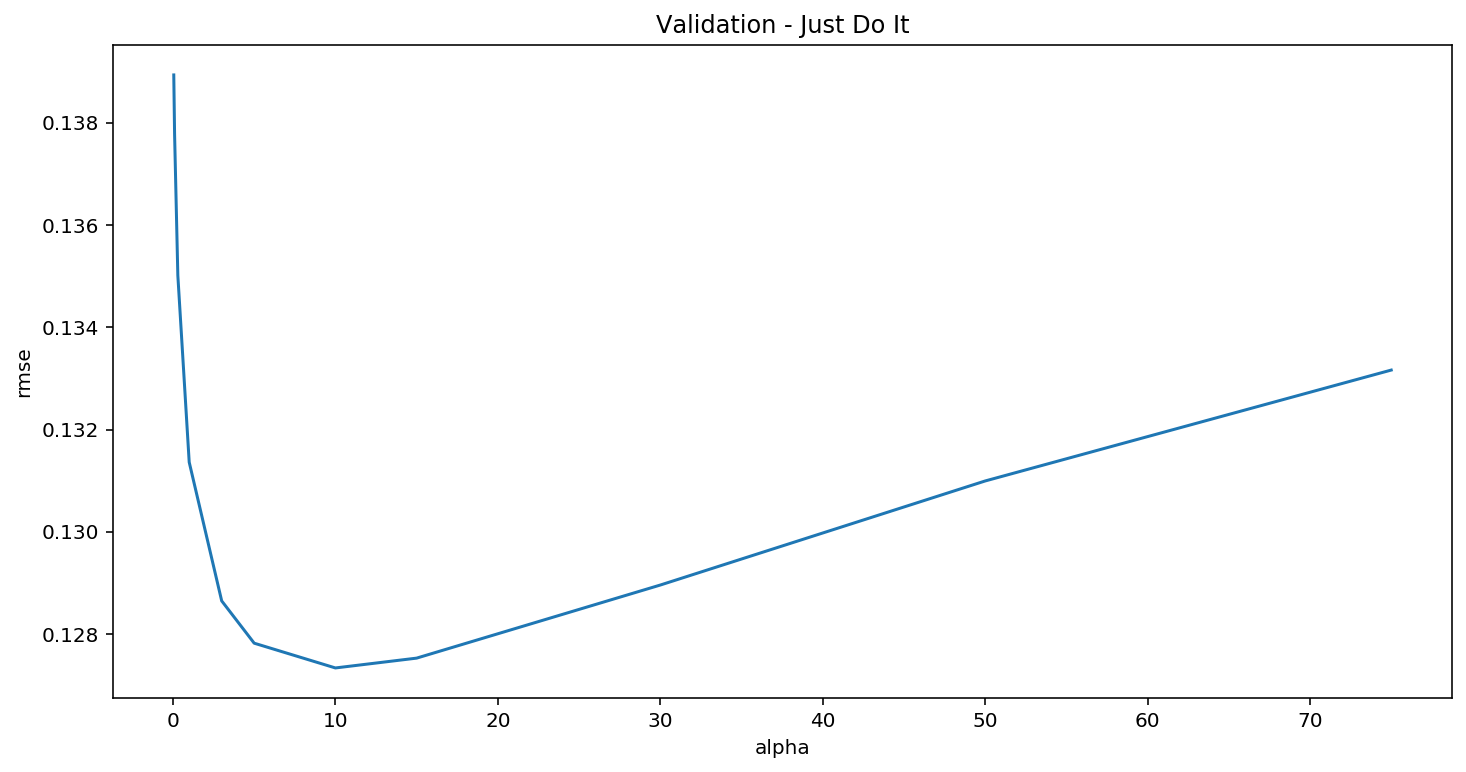

In [13]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [14]:
cv_ridge.min()

0.12733734668670751

In [15]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [16]:
rmse_cv(model_lasso).mean()

0.12256735885048123

In [17]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [19]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

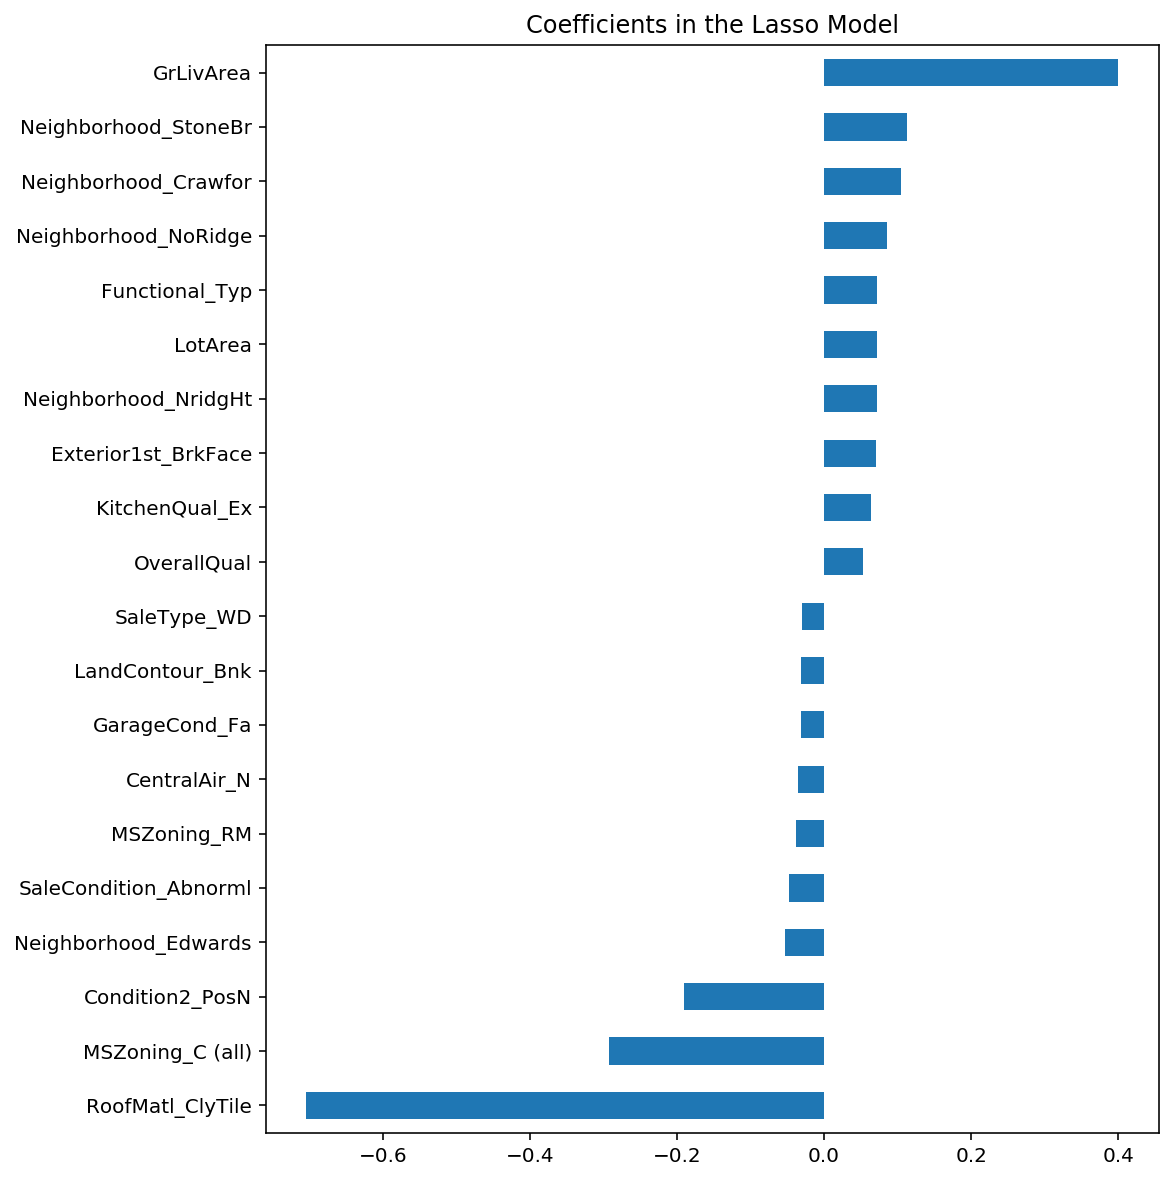

In [20]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

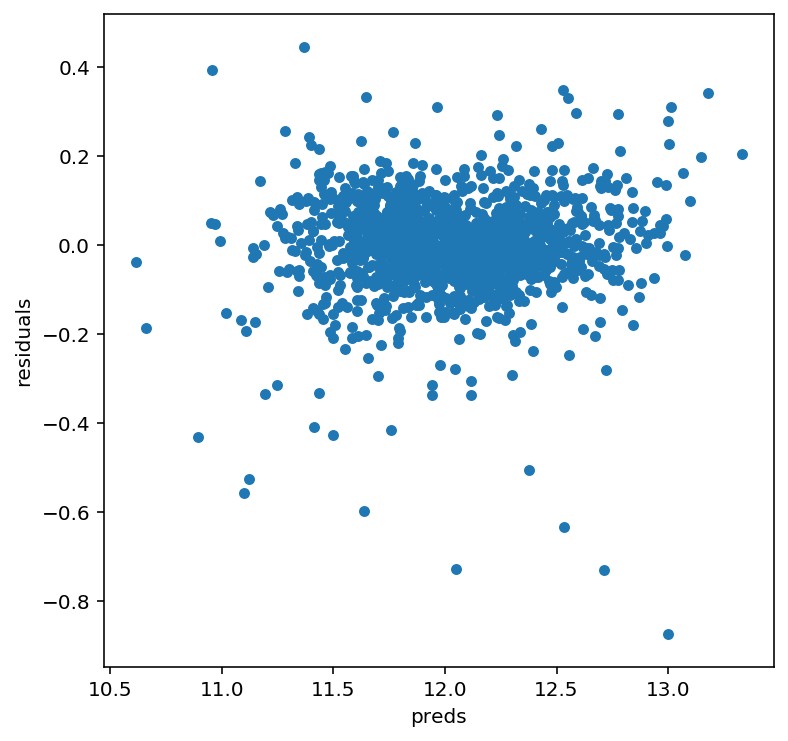

In [21]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## XGBoost

In [22]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

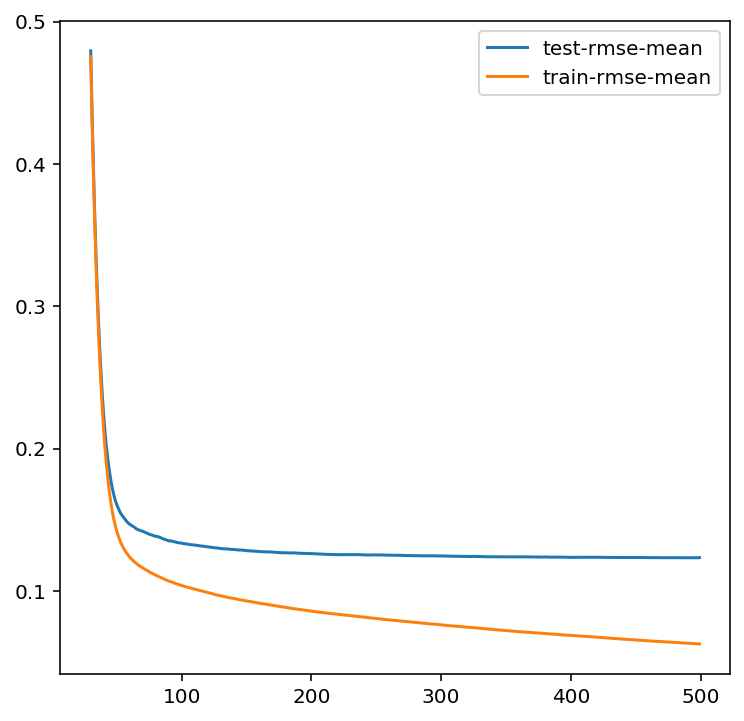

In [23]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [24]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [25]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

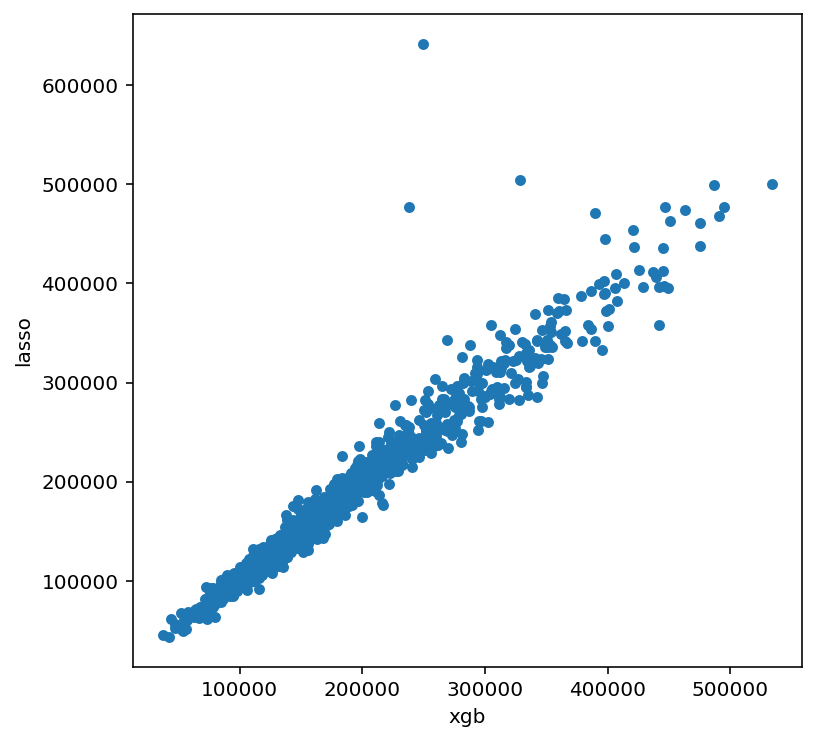

In [26]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [27]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [28]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

In [29]:
solution

id      SalePrice
0     1461  120129.316383
1     1462  153008.789313
2     1463  181999.671772
3     1464  195952.284998
4     1465  197477.812587
...    ...            ...
1454  2915   87496.343669
1455  2916   85034.583020
1456  2917  165128.542251
1457  2918  119034.149412
1458  2919  227808.934762

[1459 rows x 2 columns]